[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fvalerii/geospatial-land-classification/blob/main/notebooks/03_hybrid_transformer_integration/08_pytorch_vision_transformer.ipynb)

# 🛰️ 08: Hybrid CNN-Vision Transformer Integration (PyTorch)
### Geospatial Land Classification Study (Hybrid Phase)
(*This is the 8th module in a 9-part series exploring geospatial hybrid models.*)

## Introduction

This research module  builds a PyTorch-based hybrid Convolutional Neural Network (CNN) and Vision Transformer (ViT) for image classification. 
Starting from CNN layers that extract detailed features, such as edges and textures, from images, those features are passed to a Vision Transformer, which looks at global correlations across the entire image by attending to all spatial patches simultaneously..


### 🧪 Methodology & Technical Objectives
This research module implements a **Hybrid CNN-Vision Transformer (ViT)** architecture using the PyTorch framework. Similar to the Keras implementation in Module 07, we utilize a pre-trained CNN as a feature extractor to provide high-level spatial tokens to a Transformer encoder.

**Key Technical Focus:**
* **Deterministic Data Parity:** Utilizing a DataFrame-driven 80/10/10 split to ensure the model is trained and tested on the exact same images as the Keras baseline.
* **Intermediate Spatial Hook:** Extracting tokens from an $8 \times 8$ convolutional feature map to preserve spatial relationships for the Attention mechanism.
* **Pre-Layer Normalization (Pre-LN):** Implementing the transformer blocks with normalization before attention to ensure gradient stability.
* **Cross-Framework Benchmarking:** Preparing model artifacts for final performance comparison in Module 09.

# Table of Contents
- [Implementation Environment & Dependency Management](#Implementation-Environment-&-Dependency-Management)
- [Deterministic Seeding & Experimental Integrity](#Deterministic-Seeding-&-Experimental-Integrity)
- [Data Ingestion & Transformation Pipeline](#Data-Ingestion-&-Transformation-Pipeline)
- [Definition of pre-trained CNN backbone](#Definition-of-pre-trained-CNN-backbone)
- [Patch Embedding](#Patch-Embedding)
- [Multi-Head Self-Attention (MHSA) Module](#Multi-Head-Self-Attention-(MHSA)-Module)
- [Transformer Block](#Transformer-Block)
- [Vision Transformer (ViT) Model](#Vision-Transformer-(ViT)-Model)
- [CNN-ViT Hybrid Model](#CNN-ViT-Hybrid-Model)
- [Model Training Function](#Model-Training-Function)
- [Model Evaluation Function](#Model-Evaluation-Function)
- [Model Initialization and Training Loop](#Model-Initialization-and-Training-Loop)
- [Plotting Training vs Validation Accuracy, and Loss](#Plotting-Training-vs-Validation-Accuracy-and-Loss)


## Implementation Environment & Dependency Management

In [ ]:
import os, sys

# --- Universal Environment Setup ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Use the fast local runtime disk for satellite imagery
    BASE_DIR = '/content/'
    os.chdir(BASE_DIR)
    
    # Install specific versions for vit-research environment stability
    !pip install numpy==1.26.0 matplotlib==3.9.2 pandas==2.2.3 torch==2.7.0\
        torchvision==0.22 scikit-learn==1.7.0 requests tqdm==4.66.5 gdown Pillow --quiet
    
    print(f"✅ Environment: Google Colab. In-memory data loading will use: {BASE_DIR}")
else:
    # Local System (relative to the notebook folder)
    BASE_DIR = './' 
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

In [2]:
# Set up a quiet environment for PyTorch
import warnings, logging

# 1. Standard Python Warnings 
warnings.filterwarnings('ignore')

# 2. PyTorch Framework Logging
# This prevents PyTorch internals from sending 'INFO' or 'WARNING' logs to the console
logging.getLogger("torch").setLevel(logging.ERROR)

# 3. Third-Party Library Silence (Torchvision)
logging.getLogger("torchvision").setLevel(logging.ERROR)

### Import libraries


In [3]:
%%time
# --- Common Imports ---
import time
import requests, tarfile, gdown, subprocess
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# --- PyTorch Libraries Imports---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
print("Succesfully imported libraries")

Succesfully imported libraries
CPU times: user 4.19 s, sys: 1.34 s, total: 5.52 s
Wall time: 3.1 s


### Hardware Acceleration & GPU Utilization
Check the availability of GPU

In [4]:
# GPU Detection and Specification
# 1. Check  the GPU
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    device = torch.device("cuda")
    print(f'✅ Found GPU at: {device}')
    
    # 2. Identify the specific GPU model ONLY if detected
    print('\nHardware Specifications:')
    try:
        output = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=gpu_name,driver_version,memory.total", "--format=csv"],
            encoding="utf-8"
        )
        print(output)
    except Exception as e:
        print("⚠️ Could not run nvidia-smi. This may happen inside WSL or restricted environments.")
        print(f"Error: {e}")

else:
    device = torch.device("cpu")
    print('❌ GPU device not found.')
    print('💡 Recommendation: If in Colab, go to Runtime > Change runtime type and select "T4 GPU" for significantly faster training.')



✅ Found GPU at: cuda

Hardware Specifications:
name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 3070 Laptop GPU, 591.44, 8192 MiB



## Deterministic Seeding & Experimental Integrity

The random seeds for `random` module, NumPy, and PyTorch are assigned a fixed value and cuDNN is configured for deterministic kernels. By initializing these seeds with a constant value (for example, 42), any operations that involve randomness (such as weight initialization, data shuffling, or data augmentation) will produce the exact same sequence of random numbers every time the code is run. This is crucial for ensuring the reproducibility of experimental results and when comparing different models or hyperparameters.

Unlike TensorFlow that has a single `tf.random.set_seed(seed)`, in PyTorch it is necessary to set these seeds:
* **PyTorch CPU / GPU** – `torch.manual_seed` covers every op executed on the CPU, while `torch.cuda.manual_seed_all` applies the same seed to each GPU stream so that multi-GPU jobs stay in sync.
* **cuDNN flags** – By default cuDNN picks the fastest convolution algorithm, which can vary run-to-run. Setting `deterministic=True` forces repeatable kernels and turning `benchmark` *off* prevents the auto-tuner from replacing those kernels mid-training.

In [5]:
# Define a function to set seeds for reproducibility
SEED = 42
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    
    Args:
        seed (int): The seed value to use for all random number generators.

    Returns:
        None
    """
    # 1. Set Python core random seed
    random.seed(seed)

    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)

    # 4. Set PyTorch seed (CPU + CUDA)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    
    # 5. Force deterministic algorithms (Optional but recommended for full reproducibility)
    torch.backends.cudnn.deterministic = True # Ensures deterministic behavior for convolutional operations
    torch.backends.cudnn.benchmark = False # Disables the inbuilt cudnn auto-tuner that finds the best algorithm to use ofr the hardware.
                                           # This can lead to non-deterministic results.

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(SEED)

Reproducibility set with seed: 42


#### A `worker_init_fn` function has been defined so that each `DataLoader` worker starts from a reproducible seed as well.

PyTorch offsets each worker’s seed by default, injecting new randomness. For reproducible results, workers are set to start from **fixed** seeds so every data-augmentation decision (flip, crop, colour-jitter) is repeatable across runs. The `worker_init_fn` function re-seeds Python, NumPy, and PyTorch CPU random-number generators inside **each** worker using a simple deterministic formula (`SEED + worker_id`).  The result will be identical batches, identical gradients, and identical model checkpoints, run after run.

In [6]:
def worker_init_fn(worker_id: int) -> None:
    """Re-seed each DataLoader worker so their RNGs don't collide."""
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed) 
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

## Data Ingestion & Transformation Pipeline

The dataset is fetched directly from the public IBM Cloud Object Storage. To ensure local reproducibility and bypass proprietary library dependencies, a standard Python pipeline using `requests` and `tarfile` is implemented for automated artifact retrieval and decompression.

In [7]:
# --- Data Ingestion Configuration ---
# Matches your existing path logic: base_dir = os.path.join(extract_dir, 'images_dataSAT')
DATA_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"
TAR_FILE = os.path.join(BASE_DIR, "images-dataSAT.tar")
# For simplicity extract to the base directory.
EXTRACT_PATH = BASE_DIR

def download_and_extract(url, destination, extract_to):
    """
    Handles automated retrieval and decompression. 
    Optimized to land data directly into the project root.

    Args:
        - url (str): The URL to download the dataset from.
        - destination (str): The local file path where the downloaded archive will be saved.
        - extract_to (str): The directory where the contents of the archive will be extracted.
    
    Returns:
        None
    """
    # 1. Streamed Download
    if not os.path.exists(destination):
        print(f"🛰️ Downloading archive to: {destination}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(destination, "wb") as f, tqdm(
            desc="Downloading Dataset",
            total=total_size,
            unit='iB', unit_scale=True, unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
    else:
        print(f"✅ Archive already exists.")

    # 2. Extraction 
    expected_folder = os.path.join(extract_to, 'images_dataSAT')
    if not os.path.exists(expected_folder):
        print(f"📦 Extracting dataset to: {extract_to}")
        with tarfile.open(destination, "r") as tar:
            tar.extractall(path=extract_to)
        print("🚀 Extraction complete.")
    else:
        print(f"✅ Dataset folder '{expected_folder}' already verified.")

# Run the ingestion
download_and_extract(DATA_URL, TAR_FILE, EXTRACT_PATH)

✅ Archive already exists.
✅ Dataset folder './images_dataSAT' already verified.


### 📂 Directory Hierarchy and Class Mapping. The dataset follows a standard categorical sub-directory structure, enabling automated class inference for agricultural and non-agricultural classification.

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.

In [8]:
# Define directories
dataset_path = os.path.join(EXTRACT_PATH, 'images_dataSAT')
# Note: It's common practice for class directories to have clear names.
# Using 'class_0' and 'class_1' is good for automatic inference.
dir_non_agri = os.path.join(dataset_path, 'class_0_non_agri')
dir_agri = os.path.join(dataset_path, 'class_1_agri')

print(f"Dataset path: {dataset_path}")
print(f"Non-agricoltural images directory: {dir_non_agri}")
print(f"Agricoltural images directory: {dir_agri}")

Dataset path: ./images_dataSAT
Non-agricoltural images directory: ./images_dataSAT/class_0_non_agri
Agricoltural images directory: ./images_dataSAT/class_1_agri


### Pandas DataFrame creation

A Pandas DataFrame **`df`** of all image file paths and their class is created by recursively scanning through the `dataset_path` using `os.walk` function. 

The total count of files found is printed and the first two and last two file paths are displayed for verifcation purposes. 

In [9]:
# Create pandas dataframe of images file paths and corresponding labels
rows = []
for dir_name, _, file_names in os.walk(dataset_path):
    for file_name in file_names:
        if file_name.lower().endswith("jpg"):
            full_path = os.path.join(dir_name, file_name)
            label = os.path.basename(dir_name)
            rows.append((full_path, label))

df = pd.DataFrame(rows, columns=["file_path", "class"])

# Print count of files found and some examples of files
print(f'Total files in dataset: {len(df)}')
print(f'First two paths:\n {df.iloc[:2, 0]}\n')
print(f'Last two paths:\n {df.iloc[-2:, 0]}\n')


Total files in dataset: 6000
First two paths:
 0    ./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_...
1    ./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_...
Name: file_path, dtype: object

Last two paths:
 5998    ./images_dataSAT/class_0_non_agri/tile_S2A_MSI...
5999    ./images_dataSAT/class_0_non_agri/tile_S2A_MSI...
Name: file_path, dtype: object



In [10]:
# Split train, validation and test dataframes 80/10/10
train_val_df, test_df = train_test_split(
    df, test_size=0.10, random_state=42, stratify=df["class"]
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.111, random_state=42, stratify=train_val_df["class"]
)

### Definition of Model Hyperparameters

This cell initializes several key **hyperparameters** that will govern the training process and the model's input. Here is the list of hyperparameters:

- **`img_size`**: The spatial resolution (height and width) to which all images will be resized. This ensures that the input to the neural network is of a consistent size.
- **`batch_size`**: The number of training examples utilized in one iteration (one forward and backward pass). A larger batch size can lead to faster training but requires more memory.
- **`epochs`**: The number of times the learning algorithm will work through the entire training dataset.
- **`learning_rate`**: A crucial hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function.

- **`hybrid_model.path`**: The name of the model file that will be created after training. This is useful for saving the checkpoint while training.

In [11]:
img_size = 64
batch_size = 32

epochs = 20 # Set to the same number of epochs of the TensorFLow version for fair comparison.
learning_rate = 1e-4 # Learning rate for the optimizer. 
num_classes = 2 # Number of classes in the dataset.
attn_heads = 8 # Number of heads of the Multi-Head Self-Attention (MHSA) Layer
depth      = 4 # Number of Transformer Blocks.
embed_dim  = 256
mlp_ratio = 4 # mlp_dim = mlp_ratio * embed_dim

hybrid_model_path = "hybrid_pytorch_best.pth"

#### Definition of transformations
The sequence of operations applied to the training images, include **data augmentation** techniques like `RandomRotation`, `RandomHorizontalFlip`, and `RandomAffine`. Augmentation artificially expands the training dataset by creating modified versions of images, which helps the model generalize better and reduces overfitting. The pipeline also resizes the image, converts it to a PyTorch tensor, and normalizes its pixel values.

Types of **`transforms`** used for data augmentation: 
- `transforms.Resize` : To resize all input images to a fixed size, useful for input vector with fixed dimensions for model training
- `transforms.RandomRotation`: For geometrical rotation
- `transforms.RandomHorizontalFlip`: For Geometrical horizontal flipping
- `transforms.RandomAffine`: For adjusting to a different point-of-view

The image array is then converted to a Tensor using `transforms.ToTensor()`.

And finally, the images are normalize between [-1,1] using `transforms.Normalize`.


In [12]:
# Define training transformation pipeline

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.485, 0.456, 0.406]), std=([0.229, 0.224, 0.225]))
])


The validation dataset is just for validating the performace of the model and hence, doesn't need to augment the input images. 
The transformations applied to the images are in this case: 
- `transforms.Resize` : To resize all input images to a fixed size
- `transforms.ToTensor()`
-  `transforms.Normalize`


In [13]:
# Define the validation transformation pipeline

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.485, 0.456, 0.406]), std=([0.229, 0.224, 0.225]))
])

### Dataset split: Train, Validation, and Test

The next step in the data loading pipeline is to split the image dataset for training, validation, and test. 

The `random_split` method from `torch.utils.data` allows to randomly split the input data based on a pre-defined split ratio. 

This separation is crucial for assessing how well the model generalizes to unseen data.

The ratio used is 80% (0.8) of the dataset for training and 10% (0.10) for validation, and 10% (0.10) for the test set.


In [14]:
class DataFrameDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'filename' and 'class' columns.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df
        self.transform = transform
        
        # Consistent label mapping (Alphabetical to match Keras)
        self.classes = sorted(self.df['class'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1. Get image path and label from DataFrame
        img_path = self.df.iloc[idx]['file_path']
        label_name = self.df.iloc[idx]['class']
        
        # 2. Load image
        image = Image.open(img_path).convert("RGB")
        
        # 3. Convert label to integer
        label = self.class_to_idx[label_name]

        # 4. Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# --- Instantiate the Datasets ---

# Use the DataFrames train_df, val_df, test_df
train_dataset = DataFrameDataset(train_df, transform=train_transform)
val_dataset   = DataFrameDataset(val_df, transform=val_transform)
test_dataset  = DataFrameDataset(test_df, transform=val_transform)

# Verify the mapping matches Keras (non_agri: 0, agri: 1)
print(f"✅ Label Mapping: {train_dataset.class_to_idx}")
print(f"✅ Split Verified: Train({len(train_dataset)}), Val({len(val_dataset)}), Test({len(test_dataset)})")

✅ Label Mapping: {'class_0_non_agri': 0, 'class_1_agri': 1}
✅ Split Verified: Train(4800), Val(600), Test(600)


### Implementation of Training DataLoader

The `DataLoader` from `torch.utils.data` class is used to create a dataset generator for lazy loading of the training dataset.

- **`DataLoader`**: These objects wrap the datasets and provide an efficient, iterable way to feed data to the model in batches. `shuffle=True` for the `train_loader` ensures that the model sees the data in a different order each epoch, which helps prevent it from learning the order of the training examples. `worker_init_fn` ensures that **fixed seed** is passed to the `dataloader` for reproducibility.

Arguments: 
- `train_dataset`: The training image dataset
- `batch_size`: The number of images to be loaded in each batch
- `shuffle`: Set to *True* to load images from the dataset in random order
- `num_workers`: Number of parallel processes used to load the images. This is for optimum utilization the CPU cores to reduce the image I/O bottleneck
- `worker_init_fn`: For function to decide on data augmentation. The default is with *random seed* for better generalization or *fixed seed* for reproducible results.


In [15]:
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          worker_init_fn=worker_init_fn
                         )

### Implementation of Validation DataLoader

In [16]:
# Define validation dataloader

val_loader = DataLoader(val_dataset, 
                          batch_size=batch_size,
                          shuffle=False, # Shuffle is not necessary for the validation dataset
                          num_workers=4,
                          worker_init_fn=worker_init_fn
                         )

### Implementation of Test DataLoader

In [17]:
# Define test dataloader

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=False, # Shuffle is not necessary for the validation dataset
                          num_workers=4,
                          worker_init_fn=worker_init_fn
                         )

## Definition of Pre-Trained CNN Backbone

Creation and implementation of a **ConvNet** class. This class serves as the convolutional backbone for the hybrid CNN-ViT architecture. 
The design of this class is the **same as the training architecture**, with six progressive convolutional blocks.

- **`forward_features()`**: Returns the raw convolutional feature map (B, C, H, W) for use by the **ViT component**

- **Role in hybrid architecture**: In the hybrid model, this CNN serves as a **local feature extractor**, capturing low-level patterns, edges, and textures before passing the feature-rich representation to the Vision Transformer for global context modeling. The 256-channel output provides a rich semantic representation that the ViT can process as a sequence of tokens.


In [18]:
class ConvNet(nn.Module):
    ''' 
    Class to define the architecture same as the imported pre-trained CNN model for extracting the feature map
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024)
        )

    def forward_features_layer_13(self, x):
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == 13:    # After Conv2d and ReLU of the 256-channel block
                return x   # Shape: (Batch, 256, 8, 8)


### Download Model weights

📦 Model Persistence Note: Due to GitHub's file size constraints, the pre-trained weights for the Keras and PyTorch baselines are hosted externally. The evaluation pipelines in this module include automated fetching logic to ensure seamless reproducibility.

In [19]:
# --- Artifact Management: Remote Weight Restoration ---
def restore_model_artifacts():
    """
    Downloads pre-trained weights from remote storage if not localized.
    Ensures reproducibility for users without requiring local training phases.
    """
    artifacts = {
        #"cnn_keras_best.keras": "1oiVHiB-qNOUmBL0NRo6XCl1eSZDNQujD", # Only Pytorch model is downloaded in this module
        "cnn_pytorch_best.pth": "1BjOuHiZJlbi7UbJHYhwWBmHjj5jQQ6sC"
    }
    
    # Check if we are in Colab to use gdown efficiently
    try:
        for filename, file_id in artifacts.items():
            if not os.path.exists(filename):
                print(f"📡 Fetching {filename} from remote storage...")
                url = f'https://drive.google.com/uc?export=download&id={file_id}'
                gdown.download(url, filename, quiet=False)
            else:
                print(f"✅ {filename} is already localized.")
    except Exception as e:
        print(f"⚠️ Artifact restoration failed: {e}")

restore_model_artifacts()

✅ cnn_pytorch_best.pth is already localized.


In [20]:
# --- Configuration: Model Paths ---
pytorch_model_path = "cnn_pytorch_best.pth"

print(f"✅ Model paths set:\n - PyTorrch: {pytorch_model_path}")

✅ Model paths set:
 - PyTorrch: cnn_pytorch_best.pth


## Patch Embedding
 The **PatchEmbed** class implements the **interface** between the CNN feature extractor and the Vision Transformer, converting spatial feature maps into a sequence of tokens suitable for self-attention processing.

Unlike traditional ViT implementations that divide raw images into fixed-size patches, this hybrid approach operates on CNN feature maps. The implementation uses a **1×1 convolution** as a learned linear projection to transform the 256-dimensional CNN features ($8x8$) into the transformer's embedding dimension (256).

The transformation process involves three key steps:
1. **Channel projection**: `nn.Conv2d(in_ch, embed_dim, kernel_size=1)` reduces or expands the channel dimension from 256 to the preferred embedding size
2. **Spatial flattening**: `.flatten(2)` collapses the height and width dimensions (H×W) into a single sequence dimension
3. **Tensor reshaping**: `.transpose(1,2)` reorders dimensions from (B, D, L) to (B, L, D) where L=H×W represents the sequence length

**Integration with hybrid architecture**

In the context of the hybrid model, this patch embedding serves as the **bridge** between local CNN features and global transformer processing. Since the CNN has already extracted meaningful local patterns, the patch embedding focuses on format conversion rather than feature extraction. This design is more **efficient** than traditional ViT patch embedding since the CNN has already performed the heavy lifting of feature extraction from raw pixels.

The **output tensor** (B, L, D) represents a batch of sequences where each sequence contains L tokens (corresponding to spatial locations in the feature map) with D-dimensional embeddings ready for transformer processing.


In [21]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel=256, embed_dim=256):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1)  # 1×1 convolution
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B,L,D)
        return x

## Multi-Head Self-Attention (MHSA) Module

The **MHSA** class implements the self-attention mechanism that enables the Vision Transformer to model long-range dependencies and global context across all spatial locations in the feature map.

The implementation follows the scaled dot-product attention formula: **Attention(Q,K,V) = softmax(QK^T/√d)V**, where Q, K, and V represent query, key, and value matrices, respectively. The scaling factor 1/sqrt(d) prevents the dot products from becoming too large, which would push the softmax function into regions with extremely small gradients.

The multi-head mechanism splits the embedding dimension across multiple attention heads, allowing the model to attend to different types of relationships simultaneously. 

### Key implementation details:

- **Unified QKV projection**: A single linear layer `nn.Linear(dim, dim*3)` generates Q, K, and V matrices efficiently, reducing memory overhead compared to separate projections
- **Head reshaping**: The tensor is reshaped from (B, L, D) to (B, heads, L, d) where d = D/heads, enabling parallel processing across heads
- **Attention computation**: Matrix multiplication `torch.matmul(q, k.transpose(-2, -1))` computes attention scores, followed by scaling and softmax normalization
- **Dropout regularization**: Two dropout layers prevent overfitting - one on attention weights and one on the final output


Unlike CNNs, which have limited receptive fields, self-attention allows every token to interact directly with every other token in a single operation. This enables the model to **capture long-range spatial dependencies** that might be missed by purely convolutional approaches. 

#### In the hybrid architecture, this global modeling complements the local feature extraction performed by the CNN backbone.

The attention weights provide interpretability, showing which spatial locations the model focuses on when making predictions. This component is valuable for both performance and explainability.


In [22]:
class MHSA(nn.Module):
    def __init__(self, emb_dim, heads=8, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (emb_dim // heads) ** -0.5
        self.qkv = nn.Linear(emb_dim, emb_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(emb_dim, emb_dim)
        self.proj_drop = nn.Dropout(dropout)
    def forward(self, x):
        B, L, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, L, self.heads, -1).transpose(1, 2)  # (B, heads, L, d)
        k = k.reshape(B, L, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, L, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, L, D)
        return self.proj_drop(self.proj(x))

## Transformer Block
This code defines a building block used in modern deep learning models, especially in Vision Transformers. The class is called TransformerBlock, and it is responsible for helping the model “pay attention” to the most important parts of its input and improve the final predictions.

Implementation description:

**Layer normalization (nn.LayerNorm):** This helps stabilize and speed up training by normalizing each row of the input data, which is useful before applying attention or a neural network layer.

**Attention layer (MHSA):** This is the “Multi-Head Self Attention” block. It enables the model to look at all positions in the sequence (or image patches) at once, figuring out which ones are most important for each output. It’s like giving the model the power to focus on the key parts of an image or sentence.

**MLP (nn.Sequential):** This is a **Multi-Layer Perceptron** or a mini neural network, made up of linear (fully connected) layers, a special activation (GELU), and dropout for regularization. This MLP has:
- One linear layer that expands the input dimension by mlp_ratio (for example, 4× wider).
- A GELU activation function (a nonlinear operation, similar to ReLU).
- Dropout for regularization (helps prevent overfitting).
- Another linear layer that shrinks the data back to the original dimension.
- Another dropout layer.
Here, MLP is designed to help the model learn better representations by combining and transforming the information after the attention step.

**Skip/Residual connections (x + ...):** These connections support effective and stable training for deep neural networks by keeping pathways open for both forward information flow and backward gradient flow, making deep architectures such as transformers possible and practical. In transformers, skip connections are placed around both the attention and feedforward (MLP) sub-layers in each block. This stabilizes training of these very deep, stackable models, improves convergence speed, and lets them scale to larger datasets and more complex tasks.

In summary, this block helps models understand relationships in their input data, making them more powerful for tasks such as image and language understanding!


In [23]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads, mlp_ratio=4., dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn  = MHSA(embed_dim, heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp   = nn.Sequential(
                                    nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
                                    nn.GELU(), nn.Dropout(dropout),
                                    nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
                                    nn.Dropout(dropout))
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

## Vision Transformer (ViT) Model

The **ViT** class represents the complete Vision Transformer implementation, including patch embedding, positional encoding, transformer blocks, and a classification head for global context modeling.

The implementation uses a learnable **Classification [CLS] token**:
- **Initialization**: `nn.Parameter(torch.zeros(1, 1, embed_dim))` creates a learnable token initialized to zeros
- **Expansion**: `self.cls.expand(B, -1, -1)` replicates the token across the batch dimension
- **Prepending**: `torch.cat((cls, x), 1)` concatenates the CLS token to the beginning of the sequence
- **Classification**: Only the CLS token representation is used for final classification

This allows the CLS token to aggregate information from all spatial locations through self-attention, creating a global representation suitable for classification.

`nn.Parameter(torch.randn(1, max_tokens, embed_dim))` creates a large positional embedding matrix
and `self.pos[:, :L+1]` dynamically slices the positional embeddings to match the actual sequence length. Together, these create a **dynamic positional encoding** system for the hybrid architecture where the CNN feature map size can vary based on input image dimensions.


**`depth`** defines the number of transformerBlocks to be used in the transformer encoder
### Classification head design

The final classification pipeline includes:
1. **Final normalization**: `self.norm(x)` applies LayerNorm to the final transformer output
2. **CLS token extraction**: `[:, 0]` selects only the CLS token representation
3. **Linear classification**: `self.head` maps the CLS representation to class logits

The model's ability to handle variable sequence lengths makes it robust to different input sizes and CNN architectures, providing flexibility in deployment scenarios.


In [24]:
class ViT(nn.Module):
    def __init__(self, in_ch=256, num_classes=2,
                 embed_dim=256, depth=4, heads=8,
                 mlp_ratio=4., dropout=0.1, max_tokens=100):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)           # 1×1 conv
        self.cls   = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos   = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                          # x: (B,C,H,W)
        x = self.patch(x)                          # (B,L,D)
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)           # (B,1,D)
        x = torch.cat((cls, x), 1)                 # (B,L+1,D)
        x = x + self.pos[:, :L + 1]                # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])       # CLS token

## CNN-ViT Hybrid Model

The **CNN_ViT_Hybrid** class represents the hybrid architecture, integrating the CNN backbone with the Vision Transformer to create a unified model that leverages both local and global feature processing capabilities.
In this hybrid model, the pre-trained CNN layers can be frozen while fine-tuning the ViT and allows for **efficient attention** to operate on semantically rich CNN features rather than raw pixels
Thus, this hybrid approach combines the excellent capabilities of CNN to capture local patterns efficiently with ViTs' global context modeling, while keeping the level of complexity low.

The forward pass implements a **two-stage forward pass pipeline**:
1. **Local feature extraction**: `self.cnn.forward_features(x)` processes the input image through the CNN backbone, extracting hierarchical local features and reducing spatial resolution while increasing semantic depth.
2. **Global context modeling**: `self.vit(features)` takes the CNN feature map and processes it through the Vision Transformer for global reasoning and classification.

Despite the modular design, the entire hybrid model remains **fully differentiable**, enabling end-to-end training where gradients could flow from the classification loss back through both the ViT and CNN components. This allows the CNN to learn features that are optimally suited for the downstream transformer processing, creating a synergistic relationship between the two architectures.


In [25]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=256, depth=4, heads=8, mlp_ratio=4., dropout=.1):
        super().__init__()
        self.cnn = ConvNet(num_classes)         
        self.vit = ViT(num_classes=num_classes,
                       embed_dim=embed_dim,
                       depth=depth,
                       heads=heads,
                       mlp_ratio=mlp_ratio,
                       dropout=dropout
                       )
    def forward(self, x):
        return self.vit(self.cnn.forward_features_layer_13(x))

## Model Training Function

The **train** function implements a comprehensive training loop for one epoch, handling forward propagation, loss computation, backpropagation, and metric tracking in a memory-efficient manner.

**Training mode**
The function begins with `model.train()`, which configures the model for training by enabling dropout layers and gradient computation

**Batch processing pipeline**
Each training iteration follows a standard deep learning pipeline:

1. **Data transfer**: `x, y = x.to(device), y.to(device)` moves input data and labels to the appropriate device (CPU/GPU)
2. **Gradient reset**: `optimizer.zero_grad()` clears gradients from the previous iteration to prevent accumulation
3. **Forward pass**: `out = model(x)` computes predictions through the hybrid CNN-ViT architecture
4. **Loss computation**: `loss = criterion(out, y)` calculates cross-entropy loss between predictions and ground truth
5. **Backpropagation**: `loss.backward()` computes gradients via automatic differentiation
6. **Parameter update**: `optimizer.step()` updates model parameters using the computed gradients

**Metric accumulation**: The function tracks two key metrics:
- **Weighted loss**: `loss.item() * x.size(0)` accumulates loss weighted by batch size for accurate averaging
- **Correct predictions**: `(out.argmax(1) == y).sum().item()` counts correct predictions using argmax for multi-class classification


In [26]:
def train(model, loader, optimizer, scheduler, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    for _, (x, y) in enumerate(tqdm(loader, desc="Training  ")):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

## Model Evaluation Function
The model is evaluated by implementing inference without gradient computation to optimize memory usage and computational speed.

Two fundamental differences between using the model for evaluation and testing versus training are:
- **`torch.no_grad()`**:  Disables gradient computation and accelerate inference
- **`model.eval()`**: Switches the model to evaluation mode, ensures deterministic outputs

The **evaluation loop** mirrors the training loop structure but omits gradient-related operations.

This function **integrates with the training pipeline**, providing regular validation checks that help monitor model progress, detect overfitting, and make informed decisions about training continuation, learning rate adjustments, and model selection. The consistent interface with the training function enables easy integration into automated training workflows.


In [27]:
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for _, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

## Model Initialization and Training Loop

This cell orchestrates the complete training pipeline, from model instantiation through iterative training and validation, implementing comprehensive monitoring and logging for effective model development.

The hybrid model is instantiated with carefully chosen hyperparameters:
- **Number of classes**: `num_classes=2` configured for the specific dataset
- **Default architecture**: Uses ViT configuration (256 embedding dim, 4 transformer layer, 8 heads)

### Transfer learning integration

The commented line demonstrates transfer learning capability:
- **Pre-trained weights**: Option to load pre-trained CNN backbone weights
- **Flexible loading**: `strict=False` allows partial weight loading

**Optimizer**: The training uses the `adam` optimizer.

The training loop collects the **training and validation metrics** to track training performance and monitor generalization of the model.

### Training loop architecture

Each epoch follows a structured pipeline:
1. **Timing**: `time.time()` tracks epoch duration for performance monitoring
2. **Training phase**: Calls the training function with appropriate parameters
3. **Validation phase**: Evaluates model on validation set
4. **Logging**: Comprehensive output showing all metrics and timing
5. **Storage**: Appends metrics to tracking lists for later analysis

In [ ]:
print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model = CNN_ViT_Hybrid(num_classes=num_classes,
                            heads=attn_heads,
                            depth=depth,
                            embed_dim=embed_dim,
                            mlp_ratio=mlp_ratio,
                            dropout=0.1
                           ).to(device)

# ------------------------------------------------------------------ #
# loading pre-trained CNN weights and freeze layers
model.cnn.load_state_dict(torch.load(pytorch_model_path), strict=False)

for param in model.cnn.parameters():
    param.requires_grad = False
# ------------------------------------------------------------------ #

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

best_loss = float('inf')
training_loss_all = []
validation_loss_all = []
training_acc_all = []
validation_acc_all = []
patience = 3
counter = 0

training_time = []
for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch:02d}/{epochs:02d} started at {start_time} (UTC)")
    training_loss, training_acc = train(model, train_loader, optimizer, scheduler, criterion, device)
    validation_loss, validation_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step(validation_loss)
    print(f"Epoch {epoch:02d} | "
          f"training loss {training_loss:.4f} accuracy {training_acc:.4f} | "
          f"validation loss {validation_loss:.4f} accuracy {validation_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    training_loss_all.append(training_loss)
    validation_loss_all.append(validation_loss)
    training_acc_all.append(training_acc)
    validation_acc_all.append(validation_acc)
    training_time.append(time.time() - start_time)
    
    # Save the best model
    if validation_loss < best_loss:
        print(f"Current loss ({validation_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = validation_loss
        torch.save(model.state_dict(), hybrid_model_path)
        counter = 0
        print(f"✅ Best weights saved at Epoch {epoch}")
    else:
        counter += 1
        if counter >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch}")
            break


In [29]:
# --- Final Training Summary ---
print(f"\n{'='*30}")
print(f"🚀 HYBRID MODEL PEAK PERFORMANCE (PyTorch)")
print(f"{'='*30}")
print(f"Peak Validation Accuracy: {max(validation_acc_all):.4f}")
print(f"Minimum Validation Loss:  {min(validation_loss_all):.4f}")
print(f"{'='*30}")


🚀 HYBRID MODEL PEAK PERFORMANCE (PyTorch)
Peak Validation Accuracy: 0.9917
Minimum Validation Loss:  0.0194


### Hyperparameter cheatsheet (depth based)

The Depth of the transformer blocks signify the number of transformer blocks stacked in the model. This is one of the most important features which differentiates a ViT from CNN.

This table proides a basic overview on **how depth affects** other hyperparameters and model performance.

|  **Depth** | **Attention heads** | **Dataset Size** |  **Performance** | **learning rate** | **Feature Complexity** | **Learning Focus** |
|:---:|:---:|---|:---:|---|:---|:---:|
| **3** | 6 | size < 1000 | Underfitting - too shallow |0.001 (Shallow: can handle higher learning rates) | Low-level features | Edges, textures, basic patterns |
| **6** | 6 | size <1000 | Good for simple tasks |0.001 (Shallow: can handle higher learning rates) | Mid-level features | Shapes, object parts, spatial relationships |
| **12** | 12 | 1000 < size < 10000 | Standard choice - good balance | 0.0005 (Medium: moderate learning rate) | High-level features | Objects, semantic concepts, global context |
| **18** | 12 | 10000 < size < 100000 | High performance on complex tasks | 0.0003 (Deep: lower learning rate for stability) | High-level features | Objects, semantic concepts, global context |
| **24** | 16 | 100000 < size | Diminishing returns, overfitting risk | 0.0001 (Very deep: very small learning rate) | High-level features | Objects, semantic concepts, global context |
| **36** | 16 | 100000 < size | Likely overkill for most tasks | 0.0001 (Very deep: very small learning rate) | High-level features | Objects, semantic concepts, global context |


## Plotting Training vs Validation Accuracy, and Loss

This visualization cell creates comprehensive learning curves that provide crucial insights into model training dynamics, performance trends, and potential issues such as overfitting or underfitting.

The implementation creates two separate plots for different aspects of training analysis:
- **Accuracy plot**: Shows classification performance trends over epochs
- **Loss plot**: Reveals optimization dynamics and convergence behavior


These plots enable several important diagnostic assessments:
- **Overfitting detection**: Widening gap between training and validation metrics
- **Underfitting identification**: Both metrics plateau at suboptimal levels
- **Training completion**: Convergence indicates when to stop training
- **Hyperparameter evaluation**: Curves help assess learning rate, regularization effectiveness

These learning curves serve as essential tools for understanding model behavior, diagnosing training issues, and making informed decisions about hyperparameter adjustments, training duration, and model architecture modifications.


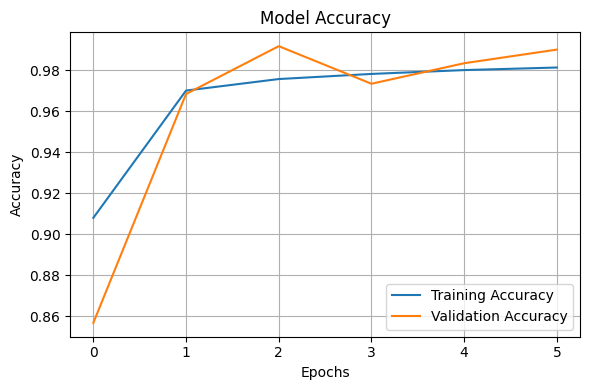

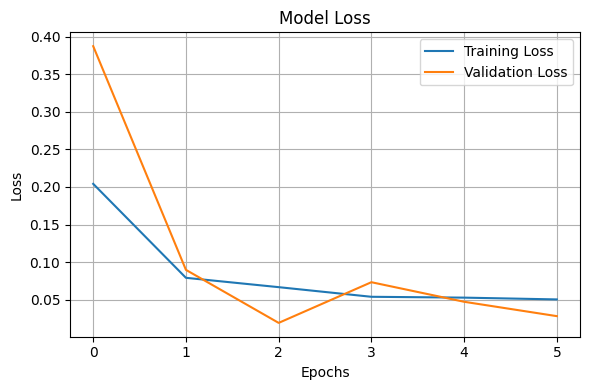

In [30]:
fig_w, fig_h = 6,4
fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Accuracy
axs.plot(training_acc_all, label='Training Accuracy')
axs.plot(validation_acc_all, label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss
axs.plot(training_loss_all, label='Training Loss')
axs.plot(validation_loss_all, label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

---
**Module 08 Conclusion:** The Hybrid architecture has been successfully ported to PyTorch, maintaining the $8 \times 8 \times 256$ spatial token configuration. By using a strictly identical data split and seed, we have prepared the two frameworks for a head-to-head performance audit.